In [1]:
# Import libraries
import os
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import fiona
from shapely.geometry import shape, mapping
from collections import OrderedDict
import itertools

# Setting for matplotlib figures export

In [3]:
# Export all illustration of each step in a folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0_aggregation'
# Declare a list with path to illustrations plots
frames = []
# Setup a counter
i = 1

In [4]:
# Set a matplotlib color map 'darkgray' >< 'yellow'
cmap = mpl.colors.ListedColormap(['darkgray', 'yellow'])
# Set matplotlib figure size
fig_size = (13, 13)
# Set matplotlib resolution dpi
resol = 250
# For plot to appear in the notebook
%matplotlib inline 

In [5]:
# Set style preset parameters from Seaborn 
sns.set_style("darkgrid")
sns.set_context("paper")

# Functions for plotting maps

In [6]:
def single_plot_darkgray(gdf, inline=True):
    global i
    gdf.plot(color='darkgray', figsize=fig_size)
    output_plot = os.path.join(output_folder,"illustration_%s.png"%i)
    frames.append(output_plot)
    plt.savefig(output_plot, dpi=resol, bbox_inches='tight')
    i+=1
    if not inline: plt.close() # Prevent the plot to be displayed

In [7]:
def double_plot_yellow(gdf, smallest_unit_index, longest_neighbor, inline=False):
    global i
    tmp_plot_gdf = gdf.copy()
    tmp_plot_gdf['temp_color_plot']=[0 for index, unit in tmp_plot_gdf.iterrows() ]
    tmp_plot_gdf.at[smallest_unit_index, "temp_color_plot"] = 1
    tmp_plot_gdf.plot(cmap=cmap, column='temp_color_plot',  figsize=fig_size)
    output_plot = os.path.join(output_folder,"illustration_%s.png"%i)
    frames.append(output_plot)
    plt.savefig(output_plot, dpi=resol, bbox_inches='tight')
    if not inline: plt.close() # Prevent the plot to be displayed
    i+=1
    tmp_plot_gdf.at[longest_neighbor[smallest_unit_index], "temp_color_plot"] = 1
    tmp_plot_gdf.plot(cmap=cmap, column='temp_color_plot',  figsize=fig_size)
    output_plot = os.path.join(output_folder,"illustration_%s.png"%i)
    frames.append(output_plot)
    plt.savefig(output_plot, dpi=resol, bbox_inches='tight')
    if not inline: plt.close() # Prevent the plot to be displayed
    i+=1

# Import initial data

In [8]:
# Set the path to the original shapefile - Please adapt the path to your own data
path = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/population/Dakar_pop_admin5_clip.shp"

In [9]:
# Read the shapefile
gdf = gpd.read_file(path)
# Keep only columns with population data (quantitative) that could be aggregated using a "grouby - sum" function
# Please adapt the column names according to your own data - Be carefull to keep the geometry column
gdf = gdf.loc[:,['geometry','CONCESSION','MENAGE', 'HOMME', 'FEMME', 'POPULATION']]
# Add a column with area (in hectares)
gdf['area'] = (gdf.geometry.area/10000).round(4)

In [10]:
# Add a new column 'dissolve_index' and fill it with the row index value 
gdf['dissolve_index']=[index for index, unit in gdf.iterrows() ]

In [11]:
# Display the attribute table
gdf.head()

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area,dissolve_index
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266,10.4294,0
1,"POLYGON ((249750.3291999996 1629808.9005, 2497...",55,124,545,575,1120,5.3131,1
2,"POLYGON ((250113.2289000005 1629602.2348, 2501...",92,123,542,508,1050,5.4988,2
3,"POLYGON ((250155.7130000005 1629917.0689, 2501...",65,131,498,460,958,3.2726,3
4,"POLYGON ((249878.8282000003 1630025.5766, 2498...",115,172,740,753,1493,7.3620,4


In [12]:
# Print number of units
print "The initial layer contains %s entities."%len(gdf)

The initial layer contains 1193 entities.


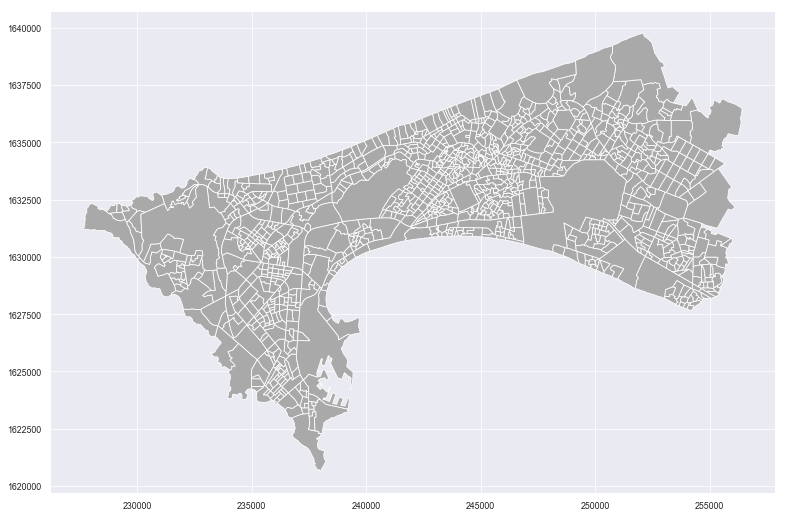

In [13]:
# Display + Save figure
single_plot_darkgray(gdf)

# Find the smallest polygon and its neighbors

In [14]:
## Define the threshold for the minimum area
thresh = 80000   # 8.0 ha

This function find the smaller unit and its neighbors and return them as a temporary shapefile (to be used in the next step).

In [15]:
# Declare a function that return a GeoDataframe with the smallest polygon and its neighbors
# 'gdf' is the name of the GeoDataframe to be used
# 'thresh_area' is the minimum desired area. Please consider using the standard area unit of the CRS of your data
# If the the area of the smallest polygon is bigger than the defined threshold 'thresh_area', the function return 'False'
def get_smallest_and_neighbors(gdf, thresh_area):
    neighbors=[]
    index_small = gdf.loc[gdf.geometry.area<thresh_area].index #
    small_count = len(index_small)
    if  small_count < 1:
        return 0, 0, 0
    else: 
        minarea = min(gdf.loc[index_small].geometry.area)  #
        smallest_unit_index = gdf.loc[gdf.geometry.area == minarea].index
        for index, unit in gdf.iterrows():
            if index == smallest_unit_index:  # Check for neighbors only for the smallest polygon
                # get 'not disjoint' countries
                neighbors = gdf[~gdf.geometry.disjoint(unit.geometry)].index.tolist()      
        return small_count, smallest_unit_index.tolist()[0], gdf.loc[neighbors]

In [16]:
# Get a dataframe with the smallest polygon and its neighborhing polygons
small_count, smallest_unit_index, gdf_small = get_smallest_and_neighbors(gdf, thresh)
# 'small_count' variable contain the number of polygons smaller thant the threshold
if small_count == 0:
    print "There is no polygons that are too small."
else:
    print "%s polygons are smaller than the user threshold (%s ha.)."%(small_count, round(thresh/10000,4))
    print "The final layer should contain about %s polygons."%(len(gdf)-small_count)

626 polygons are smaller than the user threshold (8.0 ha.).
The final layer should contain about 567 polygons.


In [17]:
# Print temporary dataframe with the smallest polygon and its neighbors
gdf_small

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area,dissolve_index
934,"POLYGON ((235474.6386000002 1630606.2511, 2354...",39,101,308,257,564,3.1316,934
942,"POLYGON ((236422.5094999997 1630868.7063, 2363...",1036,5833,14566,13663,28229,27.4811,942
946,"POLYGON ((235899.9094000002 1630496.758300001,...",158,754,1604,1674,3278,6.1482,946
1009,"POLYGON ((235587.2995999996 1630523.662900001,...",35,49,114,160,274,1.6442,1009
1010,"POLYGON ((235441.6804999998 1630784.443499999,...",115,201,532,589,1121,2.9234,1010
1011,"POLYGON ((235624.0734000001 1630598.008300001,...",32,68,201,219,421,1.0069,1011
1012,"POLYGON ((235681.0662000002 1630724.063999999,...",90,308,863,924,1788,3.5206,1012


# Find the neighbor sharing the longest border

## Convert GeoDataframe of polygon in FIONA collection

https://gist.github.com/nishadhka/97b06c21235f57552b5e471b5b6480a8

In [18]:
def convert_geodf_polygons_to_fiona(gdf):
    """Function that convert a Geodataframe into a FIONA 'Collection'"""
    def extract_polygon_geom(index,row):
        """Function that get the definition of the current dataframe row in FIONA format"""
        geom = mapping(row['geometry'])['coordinates']
        properties = zip(row[column_name].index,row[column_name])
        return {'geometry':{'coordinates': geom,'type': 'Polygon'},
                 'id':index,
                 'properties':OrderedDict(properties),
                'type': 'Feature'}

    attrib=gdf.loc[:, gdf.columns != 'geometry']
    column_name=attrib.columns
    polypd=[]
    for index, row in gdf.iterrows():
        ee=extract_polygon_geom(index,row)
        polypd.append(ee)
    return polypd

In [19]:
# Get FIONA collection format
polys = convert_geodf_polygons_to_fiona(gdf_small)

## Find the neighbor sharing the longest border with FIONA

https://gis.stackexchange.com/questions/197652/find-common-borders-of-features-and-get-their-attributes-using-fiona-and-shapely

In [20]:
def get_longest_border_index(fiona_polygon_collection, smallest_unit_index):
    """Function that return a dictionary with index of polygons as KEY 
    and index of the neighbor sharing the longest border as VALUE
    """
    id_dict={}
    max_length_dict={}

    for pol1,pol2 in  itertools.combinations(fiona_polygon_collection, 2):  # Get all possible combination of geometries
        geompol1 = shape(pol1['geometry'])
        geompol2 = shape(pol2['geometry'])
        if geompol1.touches(geompol2):  # Only if polygons touch each other
            id1 = pol1['id']
            id2 = pol2['id']
            if smallest_unit_index in [id1, id2]:
                try : 
                    length = shape(mapping(geompol1.intersection(geompol2))).length  # Get the lenght of the intersection (line)
                except: 
                    length = 0  # If intersection failed => Not a line (point) so lenght=0
                # Initialisation of the key is first time appearing in the loop
                if id1 not in id_dict.keys():   
                    id_dict[id1]=id2
                    max_length_dict[id1]=length
                if id2 not in id_dict.keys():   
                    id_dict[id2]=id1
                    max_length_dict[id2]=length
                # Update the VALUE of dictionary if the lenght is bigger than the current longest known in the dictionnary
                if length > max_length_dict[id1]:  
                    id_dict[id1]=id2
                    max_length_dict[id1]=length
                if length > max_length_dict[id2]:  
                    id_dict[id2]=id1
                    max_length_dict[id2]=length
    return id_dict

In [21]:
# Get a dictionnary with neighbors index
longest_neighbor = get_longest_border_index(polys, smallest_unit_index)

In [22]:
for index in longest_neighbor.keys():
    print "Entity at index ",index," shares its longest border with entity at index ",longest_neighbor[index]

Entity at index  934  shares its longest border with entity at index  1011
Entity at index  1010  shares its longest border with entity at index  1011
Entity at index  942  shares its longest border with entity at index  1011
Entity at index  1009  shares its longest border with entity at index  1011
Entity at index  946  shares its longest border with entity at index  1011
Entity at index  1011  shares its longest border with entity at index  1009
Entity at index  1012  shares its longest border with entity at index  1011


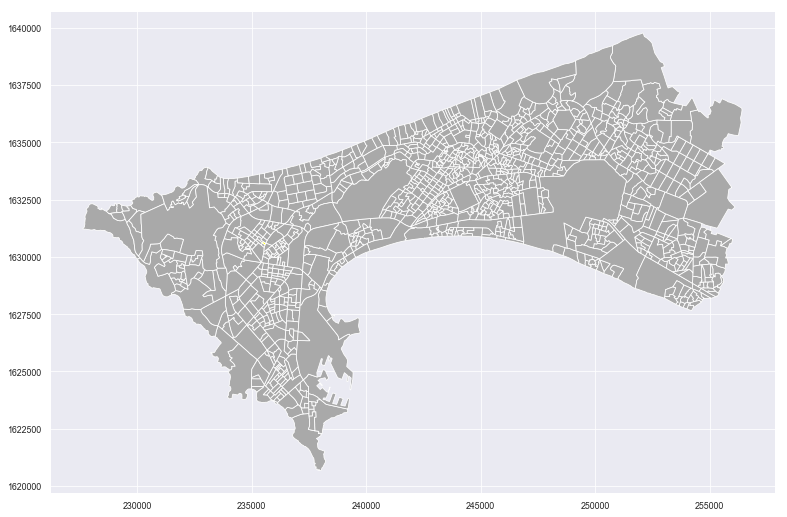

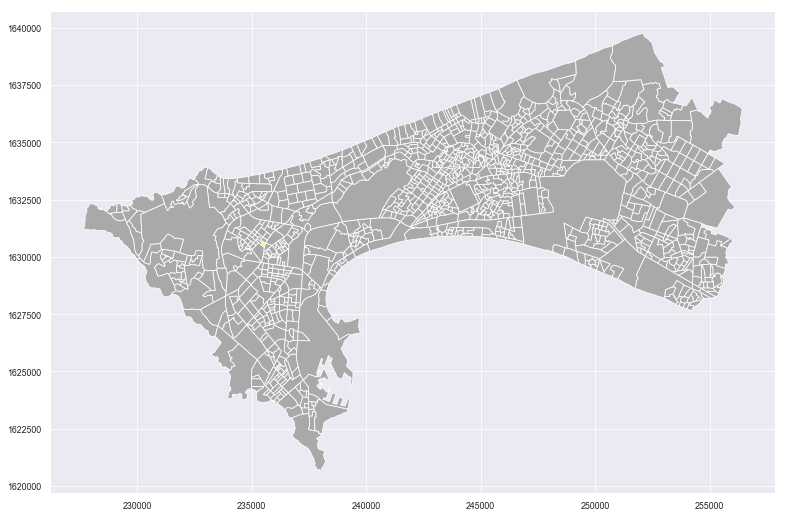

In [23]:
# Display + Save figure
double_plot_yellow(gdf, smallest_unit_index, longest_neighbor, inline=True)

## Update the initial dataframe

In [24]:
## Update "dissolve_index" column of the smallest polygon 
gdf.at[smallest_unit_index, "dissolve_index"] = int(longest_neighbor[smallest_unit_index])

## Dissolve polygons with same 'dissolve_index'

In [25]:
def dissolve_admin(gdf, dissolve_column, aggfunc='sum'):
    # Use dissolve function of Geopandas
    tmp = gdf.dissolve(by=dissolve_column, aggfunc=aggfunc, as_index=False)
    # Reset the column 'dissolve_index' with the nwe index of the table 
    tmp['dissolve_index']=[index for index, unit in tmp.iterrows() ]
    return tmp

In [26]:
# Dissolve according to 'dissolve_index' column
gdf = dissolve_admin(gdf, dissolve_column='dissolve_index', aggfunc='sum')
# Display the attribute table
gdf.head()

,dissolve_index,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,area
0,0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266,10.4294
1,1,"POLYGON ((249750.3291999996 1629808.9005, 2497...",55,124,545,575,1120,5.3131
2,2,"POLYGON ((250113.2289000005 1629602.2348, 2501...",92,123,542,508,1050,5.4988
3,3,"POLYGON ((250155.7130000005 1629917.0689, 2501...",65,131,498,460,958,3.2726
4,4,"POLYGON ((249878.8282000003 1630025.5766, 2498...",115,172,740,753,1493,7.3620


# Execute again until there is no more small polygons

In [27]:
# Get a dataframe with the smallest polygon and its neighborhing polygons
small_count, smallest_unit_index, gdf_small = get_smallest_and_neighbors(gdf, thresh)

# While loop
if small_count == 0:
    print "There is no polygons that are too small."
else:   
    while small_count > 0:
        print "There remains %s polygons that are too small."%small_count
        # Get FIONA collection format
        polys = convert_geodf_polygons_to_fiona(gdf_small)
        # Get a dictionnary with neighbors index
        longest_neighbor = get_longest_border_index(polys, smallest_unit_index)
        # Display + Save figure
        double_plot_yellow(gdf, smallest_unit_index, longest_neighbor, inline=False)
        ## Update "dissolve_index" column of the smallest polygon 
        gdf.at[smallest_unit_index, "dissolve_index"] = int(longest_neighbor[smallest_unit_index])
        # Dissolve according to 'dissolve_index' column
        gdf = dissolve_admin(gdf, dissolve_column='dissolve_index', aggfunc='sum')
        # Display + Save figure
        #single_plot_darkgray(gdf, inline=False)
        # Get a dataframe with the smallest polygon and its neighborhing polygons
        small_count, smallest_unit_index, gdf_small = get_smallest_and_neighbors(gdf, thresh)

There remains 625 polygons that are too small.
There remains 624 polygons that are too small.
There remains 623 polygons that are too small.
There remains 622 polygons that are too small.
There remains 621 polygons that are too small.
There remains 620 polygons that are too small.
There remains 619 polygons that are too small.
There remains 618 polygons that are too small.
There remains 617 polygons that are too small.
There remains 616 polygons that are too small.
There remains 615 polygons that are too small.
There remains 614 polygons that are too small.
There remains 613 polygons that are too small.
There remains 612 polygons that are too small.
There remains 611 polygons that are too small.
There remains 610 polygons that are too small.
There remains 609 polygons that are too small.
There remains 608 polygons that are too small.
There remains 607 polygons that are too small.
There remains 606 polygons that are too small.
There remains 605 polygons that are too small.
There remains

There remains 402 polygons that are too small.
There remains 401 polygons that are too small.
There remains 400 polygons that are too small.
There remains 399 polygons that are too small.
There remains 398 polygons that are too small.
There remains 397 polygons that are too small.
There remains 395 polygons that are too small.
There remains 394 polygons that are too small.
There remains 393 polygons that are too small.
There remains 392 polygons that are too small.
There remains 391 polygons that are too small.
There remains 390 polygons that are too small.
There remains 389 polygons that are too small.
There remains 387 polygons that are too small.
There remains 386 polygons that are too small.
There remains 385 polygons that are too small.
There remains 383 polygons that are too small.
There remains 382 polygons that are too small.
There remains 381 polygons that are too small.
There remains 380 polygons that are too small.
There remains 379 polygons that are too small.
There remains

There remains 184 polygons that are too small.
There remains 182 polygons that are too small.
There remains 181 polygons that are too small.
There remains 180 polygons that are too small.
There remains 179 polygons that are too small.
There remains 178 polygons that are too small.
There remains 177 polygons that are too small.
There remains 176 polygons that are too small.
There remains 174 polygons that are too small.
There remains 172 polygons that are too small.
There remains 171 polygons that are too small.
There remains 170 polygons that are too small.
There remains 169 polygons that are too small.
There remains 168 polygons that are too small.
There remains 166 polygons that are too small.
There remains 164 polygons that are too small.
There remains 163 polygons that are too small.
There remains 162 polygons that are too small.
There remains 161 polygons that are too small.
There remains 160 polygons that are too small.
There remains 158 polygons that are too small.
There remains

In [31]:
# Print number of units
print "The resulting layer contains %s entities."%len(gdf)

The resulting layer contains 677 entities.


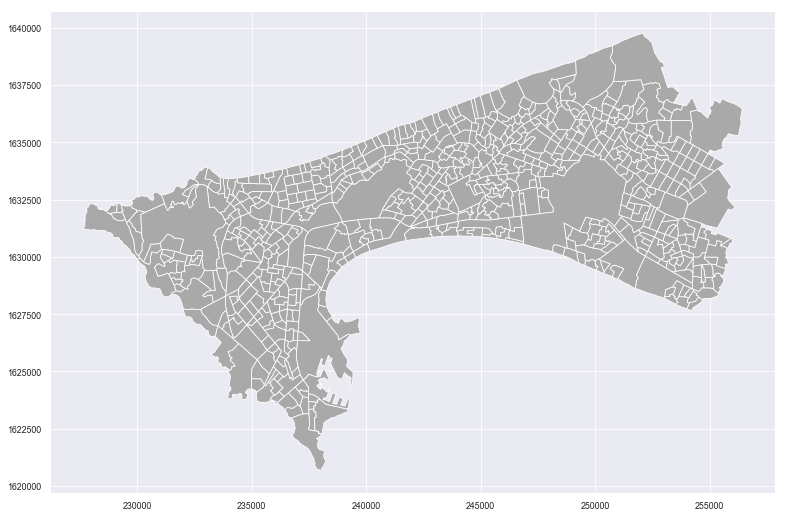

In [33]:
# Display + Save figure
single_plot_darkgray(gdf)

# Export result

### Export final result as shapefile

In [32]:
# Set the path to the shapefile to be created
shape_export = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0_aggregation/Dakar_level1.shp'
# Export
gdf.to_file(driver='ESRI Shapefile',filename=shape_export)

## Create a gif from all plots

To use this functionnality, pleae first install [imageio](https://github.com/imageio/imageio).

In [29]:
import imageio
import glob
from PIL import Image
from numpy import array
imagestack = []
for frame in frames:
    img = Image.open(frame)
    arr = array(img)
    imagestack.append(arr)
imageio.mimsave(os.path.join(output_folder,"illustration.gif"), imagestack, fps=3)

## Zip the frames for archive

In [30]:
import zipfile
with zipfile.ZipFile(os.path.join(output_folder,"frame_gif.zip"), 'w', zipfile.ZIP_DEFLATED) as myzip:
    [myzip.write(frame,os.path.basename(frame)) for frame in frames]
    myzip.close()

## Delete the individual plots files

In [34]:
for frame in frames:
    os.remove(frame)